Import utils functions

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),
                             "../src"))
from utils import *

Import required librares

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
from torch import nn

In [4]:
SEED = 42

## 1. Make classification data

In [5]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = SEED)

X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

Note here that there are 2 unique values per y value.

In [6]:
circles = pd.DataFrame({'X1': X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [7]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Great! No class imbalance. Also notice that this is a binary classification problem because there are only 2 target labels.

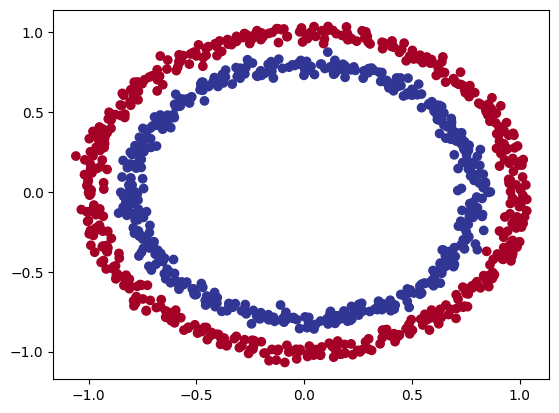

In [8]:
plt.scatter(x = X[:, 0],
            y = X[:,1], 
            c = y,
            cmap = plt.cm.RdYlBu)

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

Turning our data into tensors

In [10]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

We have to cast the X and y with torch.float because numpy's default is float64 but torch's default is float32. If we do not cast it, we'll have tensors in torch.float64 which might cause problems in training.

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Creating the model

In [13]:
device = get_device()
print(device)

mps


Coding a small neural network to handle classification

In [14]:
class ToyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features = 2,
                                       out_features = 5)
        self.linear_layer2 = nn.Linear(in_features = 5,
                                       out_features = 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Return logits - these are not passed through sigmoid activation yet
        return self.linear_layer2(self.linear_layer1(x))

In [38]:
toyModel = ToyClassifier().to(device)
next(toyModel.parameters()).device

device(type='mps', index=0)

In [16]:
# Alternatively
toyModel2 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 2)
).to(device)

toyModel2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=2, bias=True)
)

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module ` subclass

In [17]:
toyModel.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.3080, -0.1766],
                      [ 0.1429,  0.5718],
                      [-0.1813, -0.4868],
                      [ 0.2627,  0.6405],
                      [ 0.3143, -0.2234]], device='mps:0')),
             ('linear_layer1.bias',
              tensor([ 0.1429,  0.3516, -0.5693, -0.6570,  0.3903], device='mps:0')),
             ('linear_layer2.weight',
              tensor([[-0.0837, -0.2310, -0.2393,  0.0918,  0.1136]], device='mps:0')),
             ('linear_layer2.bias', tensor([0.2305], device='mps:0'))])

In [18]:
with torch.inference_mode():
    untrained_preds = toyModel(X_test.to(device))
untrained_preds.shape

torch.Size([200, 1])

In [19]:
untrained_preds[:3]

tensor([[0.2632],
        [0.2896],
        [0.2161]], device='mps:0')

These are logits that have not been activated using the sigmoid activation function - this is the required activation function for binary classification.

In [20]:
# nn.BCEWithLogitsLoss has a sigmoid activation built-in. According to 
# Torch docs, this is more stable than using nn.BCELoss and adding sigmoid layer
# nn.BCELoss has no sigmoid activation built-in. 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(toyModel.parameters(),
                            lr = 0.01)

In [22]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred))*100

In [24]:
toyModel.eval()
with torch.inference_mode():
    y_pred_labels = torch.round(
        torch.sigmoid(toyModel(X_test.to(device)))
    )

y_pred_labels.shape

torch.Size([200, 1])

Yup we need to squeeze the output

In [26]:
y_pred_labels.squeeze()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='mps:0')

In [28]:
print(torch.eq(y_test, y_pred_labels.squeeze().to('cpu'))[:5])

tensor([ True, False,  True, False,  True])


In [71]:
torch.manual_seed(SEED)
epochs = 100
train_losses, test_losses = list(), list()
train_acc, test_acc = list(), list()

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
toyModel = ToyClassifier().to(device)

for epoch in range(epochs):
    
    ### Train setup
    # Get train logits
    train_logits = toyModel(X_train).squeeze()
    
    # Get train predictions from logits
    train_pred = torch.round(
        torch.sigmoid(train_logits)
    )
    
    # Compute loss and accuracy
    train_loss = loss_fn(train_logits, y_train)
    train_accuracy = accuracy_fn(y_true = y_train, y_pred = train_pred)
    
    #Zero grad
    optimizer.zero_grad()
    
    #Backpropagation
    train_loss.backward()
    
    #Optimizer step
    optimizer.step()
    
    ### Test setup
    toyModel.eval()
    with torch.inference_mode():
        
        #Forward pass
        test_logits = toyModel(X_test).squeeze()
        test_pred = torch.round(
            torch.sigmoid(test_logits)
        )
        
        #Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true = y_test,
                                    y_pred = test_pred)
        if epoch % 10==0:
            print(f'Epoch: {epoch}, train_loss: {train_loss:.5f}, train_acc: {train_accuracy}%, test_loss: {test_loss:.5f}, test_acc: {test_accuracy}%')


Epoch: 0, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 10, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 20, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 30, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 40, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 50, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 60, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 70, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 80, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%
Epoch: 90, train_loss: 0.69569, train_acc: 50.0%, test_loss: 0.69741, test_acc: 50.0%


In [53]:
# Get helper functions

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists. Skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
    Path("helper_functions.py").rename("../src/helper_functions.py")


In [15]:
from helper_functions import *

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <D9493EF5-8DAB-3A5D-85D5-684F04544B84> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3F9923D2-81A5-3EC8-9739-EC0C1C816132> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


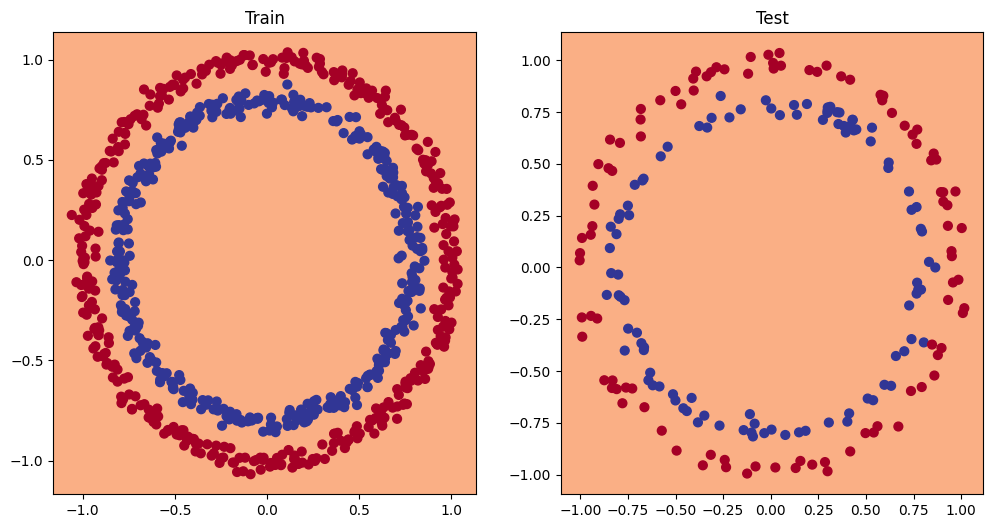

In [72]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(toyModel,
                       X_train,
                       y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(toyModel,
                       X_test,
                       y_test)

We cannot separate the circular data with linear layers

## Improving a model

In [67]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,
                                out_features=10)
        self.layer2 = nn.Linear(in_features=10,
                                out_features=10)
        self.layer3 = nn.Linear(in_features=10,
                                out_features=1)
    def forward(self, x):
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        return z

In [68]:
model1 = CircleModel().to(device)
model1

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    CircleModel().parameters(),
    lr = 0.01
)

torch.manual_seed(SEED)
epochs = 1000
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
model1 = CircleModel().to(device)

for epoch in range(epochs):
    train_logits = model1(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))
    train_loss = loss_fn(train_logits, y_train)
    train_accuracy = accuracy_fn(y_train, train_pred)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model1.eval()
    with torch.inference_mode():
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_pred)
        if epoch%100==0:
            print(f"Epoch: {epoch}, Train loss: {train_loss:.5f}, Train accuracy: {train_accuracy}%, Test loss: {test_loss:.5f}, Test accuracy: {test_accuracy:}% ")

Epoch: 0, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 100, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 200, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 300, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 400, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 500, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 600, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 700, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 800, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 
Epoch: 900, Train loss: 0.69396, Train accuracy: 50.875%, Test loss: 0.69261, Test accuracy: 51.0% 


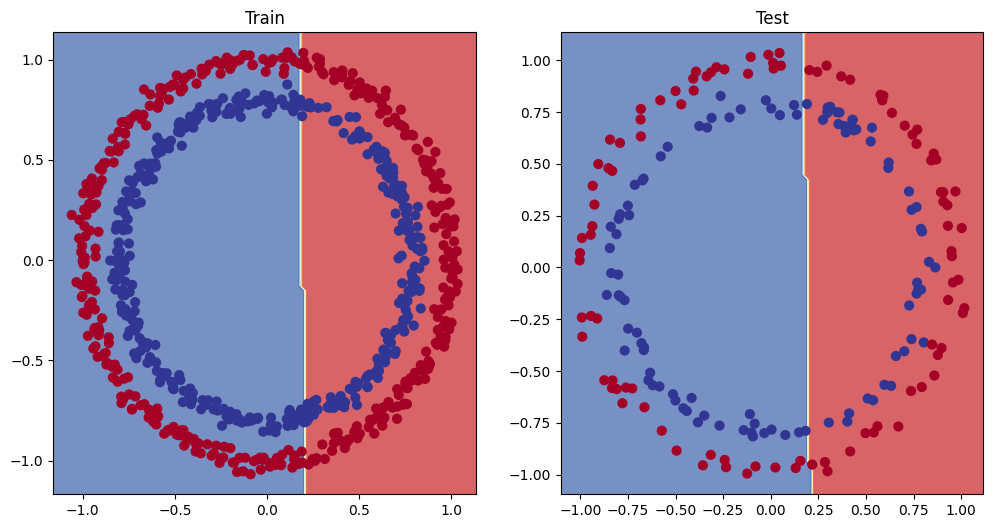

In [70]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

Still a coin toss... Let's create a straight line dataset to see if our model is learning anything

In [74]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:3], y_regression[:3]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140]]))

In [75]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size = 0.2, random_state = SEED)
X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

(torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]))

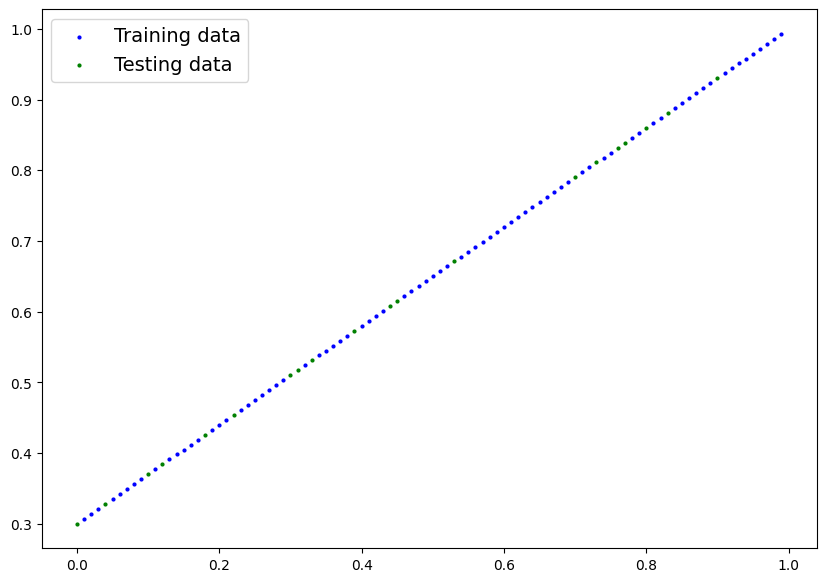

In [76]:
plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

In [77]:
model1

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [82]:
# We need to change the in-features of model1

model2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features= 10, out_features = 10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [83]:
loss_reg = nn.L1Loss()
optim_reg = torch.optim.SGD(params = model2.parameters(),
                            lr = 0.01)
epochs = 1000
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
    y_pred = model2(X_train_reg)
    loss = loss_reg(y_pred, y_train_reg)
    optim_reg.zero_grad()
    loss.backward()
    optim_reg.step()
    
    model2.eval()
    with torch.inference_mode():
        test_pred = model2(X_test_reg)
        test_loss = loss_reg(test_pred, y_test_reg)
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, train loss: {loss}, test_loss: {test_loss}')
    

/opt/homebrew/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, train loss: 0.8427693247795105, test_loss: 0.7625661492347717
Epoch: 100, train loss: 0.01716393418610096, test_loss: 0.034288108348846436
Epoch: 200, train loss: 0.016818290576338768, test_loss: 0.03289327397942543
Epoch: 300, train loss: 0.017720043659210205, test_loss: 0.030457496643066406
Epoch: 400, train loss: 0.017917443066835403, test_loss: 0.027379143983125687
Epoch: 500, train loss: 0.017442256212234497, test_loss: 0.026775313541293144
Epoch: 600, train loss: 0.01822974532842636, test_loss: 0.026476984843611717
Epoch: 700, train loss: 0.018757497891783714, test_loss: 0.025057747960090637
Epoch: 800, train loss: 0.0176230575889349, test_loss: 0.02522759512066841
Epoch: 900, train loss: 0.01751610077917576, test_loss: 0.02457858994603157


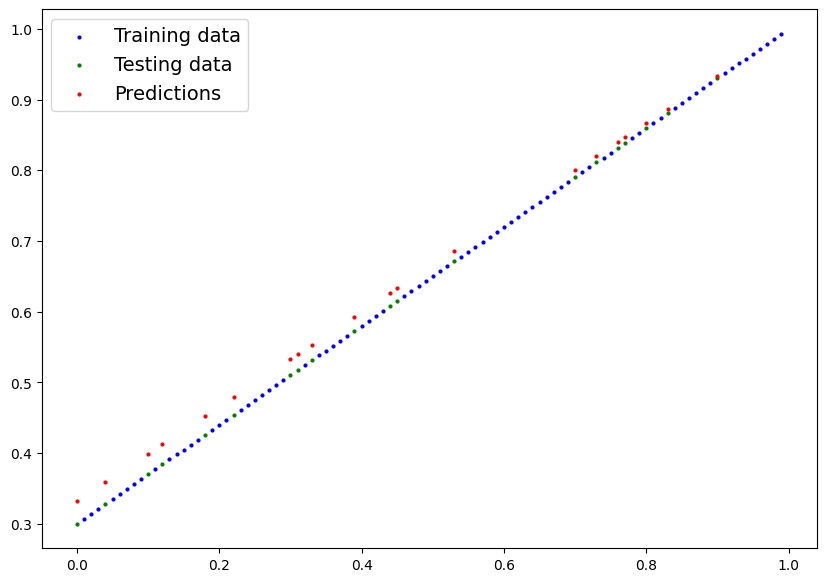

In [86]:
with torch.inference_mode():
    y_preds = model2(X_test_reg)

plot_predictions(X_train_reg.cpu(),
                 y_train_reg.cpu(),
                 X_test_reg.cpu(),
                 y_test_reg.cpu(),
                 y_preds.cpu())

So our model is capable of learning something! We cannot use a linear layer to learn non-linear datasets. Time to build a model with non-linearity.

In [90]:
import torch
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer3 = nn.Linear(in_features = 10, out_features =1)
        self.relu = nn.ReLU()
    def forward(self, x):
        z = self.layer1(x)
        z = self.relu(z)
        z = self.layer2(z)
        z = self.relu(z)
        z = self.layer3(z)
        return z

In [105]:
model3 = CircleModelV2().to(device)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


SEED = 2023
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

epochs = 1000
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(),
                            lr = 0.1)

for epoch in range(epochs):
    train_logits = model3(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))
    train_acc = accuracy_fn(y_train, train_pred)
    train_loss = loss_fn(train_logits, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(y_test, test_pred)
        test_loss = loss_fn(test_logits, y_test)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.5f}, Train accuracy: {train_acc}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc}%")

Epoch: 0 | Train loss: 0.69262, Train accuracy: 50.875% | Test loss: 0.69534, Test accuracy: 47.0%
Epoch: 100 | Train loss: 0.68899, Train accuracy: 52.625% | Test loss: 0.69119, Test accuracy: 49.0%
Epoch: 200 | Train loss: 0.68526, Train accuracy: 53.0% | Test loss: 0.68687, Test accuracy: 52.5%
Epoch: 300 | Train loss: 0.67964, Train accuracy: 62.5% | Test loss: 0.68083, Test accuracy: 61.0%
Epoch: 400 | Train loss: 0.67057, Train accuracy: 61.5% | Test loss: 0.67173, Test accuracy: 61.5%
Epoch: 500 | Train loss: 0.65489, Train accuracy: 63.24999999999999% | Test loss: 0.65771, Test accuracy: 64.0%
Epoch: 600 | Train loss: 0.62561, Train accuracy: 74.375% | Test loss: 0.63235, Test accuracy: 71.0%
Epoch: 700 | Train loss: 0.56615, Train accuracy: 92.75% | Test loss: 0.58230, Test accuracy: 91.0%
Epoch: 800 | Train loss: 0.46143, Train accuracy: 98.0% | Test loss: 0.49020, Test accuracy: 95.5%
Epoch: 900 | Train loss: 0.32045, Train accuracy: 99.375% | Test loss: 0.36154, Test accura

Much better... but the trend change after 400 epochs is interesting. This might be due to the device being "mps". Using "cuda" devices with the same code have been shown to have better results, but the spirit of the improvement is there.

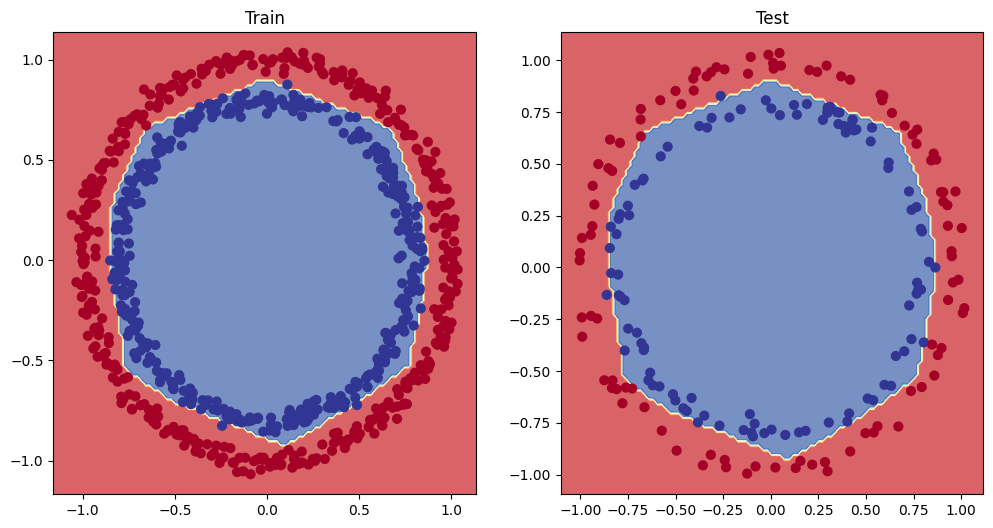

In [106]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

Awesome! It looks like our previous performance was poor because the learning rate was too low so the loss was stuck in a "well".

## Replicating non-linear activation functions

In [107]:
A = torch.arange(-10, 10, 1).type(torch.float32)
A.dtype

torch.float32

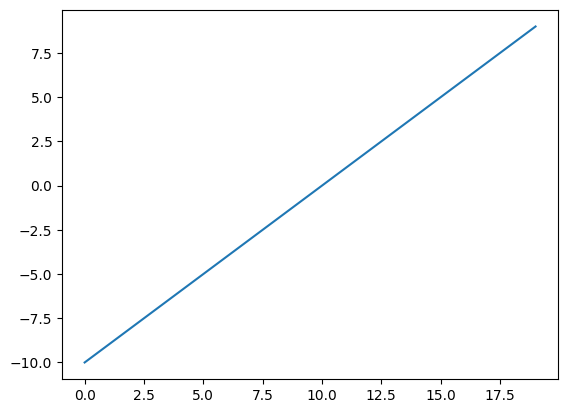

In [108]:
plt.plot(A)

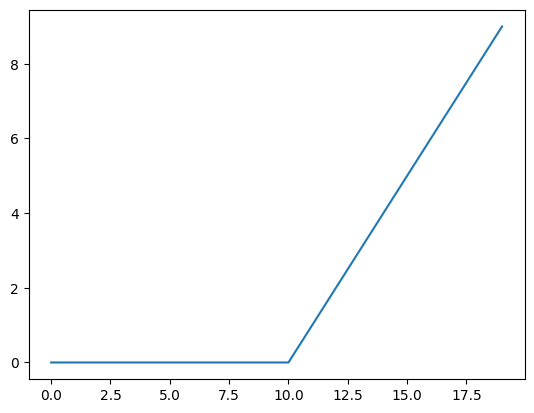

In [109]:
plt.plot(torch.relu(A))

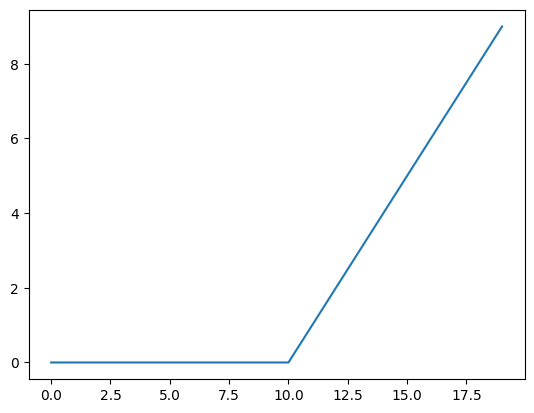

In [110]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

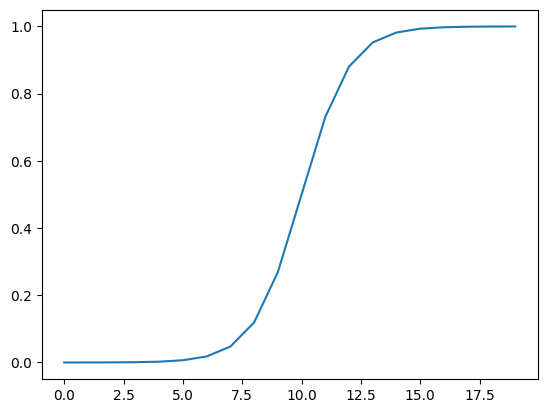

In [111]:
plt.plot(torch.sigmoid(A))

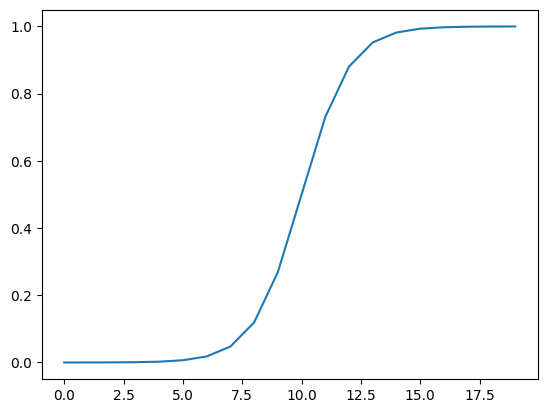

In [112]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1/(1+torch.exp(-x))

plt.plot(sigmoid(A))

## Multi-class classification in PyTorch
We're going to use the softmax function here

### Building the dataset

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
SEED = 42

# Create data
X_blob, y_blob = make_blobs(n_samples = 1000,
                             n_features = NUM_FEATURES,
                             centers = NUM_CLASSES,
                             cluster_std = 1.5, #makes the clusters more challenging
                             random_state = SEED)

X, y = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = SEED)

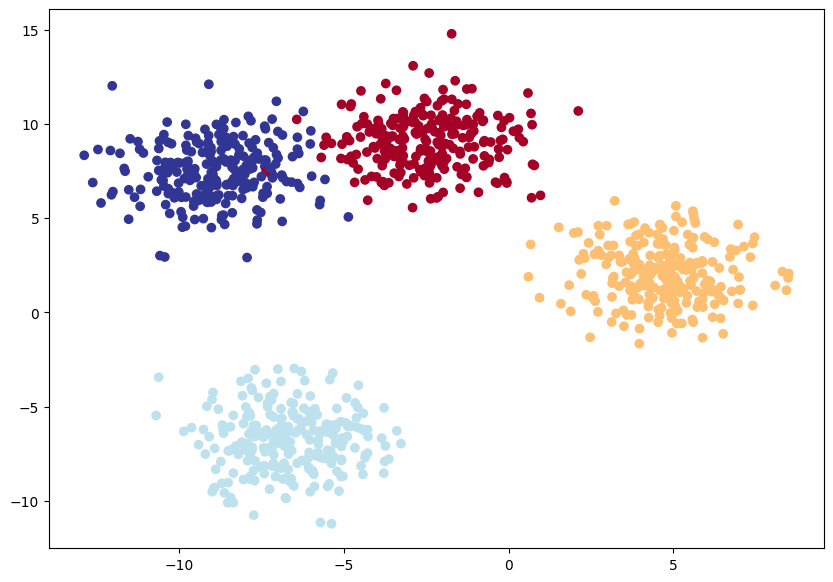

In [4]:
plt.figure(figsize = (10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu);

In [5]:
X_train.shape 

torch.Size([800, 2])

Note that we have 2 in_features. We need 4 output features becuase we have 1 probability prediction per class

### Build the model

In [7]:
device = get_device()
print(device)

mps


In [8]:
class Classifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Class constructor

        Args:
            input_features (int): Number of input features to model
            output_features (int): Number of classes
            hidden_units (int, optional): Number of hidden units. Defaults to 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,
                      out_features = output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

In [9]:
blob_model = Classifier(input_features = 2,
                        output_features = 4).to(device)
blob_model

Classifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
X_test = X_test.to(device)
blob_model.eval()
with torch.inference_mode():
    out = blob_model(X_test)
out.shape, out[:5]

(torch.Size([200, 4]),
 tensor([[-0.2582, -0.0120, -0.2107, -0.0237],
         [-0.8810, -0.7208,  0.1124, -0.8637],
         [-0.5839, -0.2455, -0.0351, -0.8162],
         [-0.1258,  0.1090, -0.2099, -0.1487],
         [-0.0129, -0.9665,  0.0611,  0.1838]], device='mps:0'))

In [11]:
y_test[:5]

tensor([1, 3, 2, 1, 0])

We need to convert the model's outputs (logits) to prediction labels

In [12]:
probs = torch.softmax(out, 
              dim = 1 #the dimension parameter is important
              )[:5]
probs

tensor([[0.2178, 0.2786, 0.2284, 0.2753],
        [0.1697, 0.1992, 0.4583, 0.1727],
        [0.2030, 0.2847, 0.3514, 0.1609],
        [0.2403, 0.3039, 0.2209, 0.2349],
        [0.2718, 0.1047, 0.2927, 0.3308]], device='mps:0')

In [13]:
torch.argmax(probs, dim = 1)

tensor([1, 2, 2, 1, 3], device='mps:0')

Tada! Now we have the probabilities

In [16]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blob_model.parameters(),
                            lr = 0.1)

epochs = 100
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

for epoch in range(epochs):
    
    blob_model.train()
    train_logits = blob_model(X_train)
    train_pred = torch.softmax(train_logits, dim = 1).argmax(dim=1)
    train_loss = loss_fn(train_logits, y_train)
    train_accuracy = accuracy_fn(y_train, train_pred)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_test)
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_pred)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.5f}, Train accuracy: {train_accuracy}% | Test loss: {test_loss:.5f}, Test accuracy: {test_accuracy}%")
    

Epoch: 0 | Train loss: 1.34540, Train accuracy: 47.75% | Test loss: 1.07582, Test accuracy: 43.0%
Epoch: 10 | Train loss: 0.50177, Train accuracy: 91.125% | Test loss: 0.45709, Test accuracy: 96.5%
Epoch: 20 | Train loss: 0.22794, Train accuracy: 99.0% | Test loss: 0.20971, Test accuracy: 100.0%
Epoch: 30 | Train loss: 0.11256, Train accuracy: 99.125% | Test loss: 0.10394, Test accuracy: 99.5%
Epoch: 40 | Train loss: 0.07332, Train accuracy: 99.125% | Test loss: 0.06639, Test accuracy: 99.5%
Epoch: 50 | Train loss: 0.05639, Train accuracy: 99.125% | Test loss: 0.04951, Test accuracy: 99.5%
Epoch: 60 | Train loss: 0.04736, Train accuracy: 99.125% | Test loss: 0.04021, Test accuracy: 99.5%
Epoch: 70 | Train loss: 0.04189, Train accuracy: 99.125% | Test loss: 0.03438, Test accuracy: 99.5%
Epoch: 80 | Train loss: 0.03828, Train accuracy: 99.125% | Test loss: 0.03040, Test accuracy: 99.5%
Epoch: 90 | Train loss: 0.03574, Train accuracy: 99.125% | Test loss: 0.02753, Test accuracy: 99.5%


In [17]:
blob_model.eval()
with torch.inference_mode():
    y_logits = blob_model(X_test)
    y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')

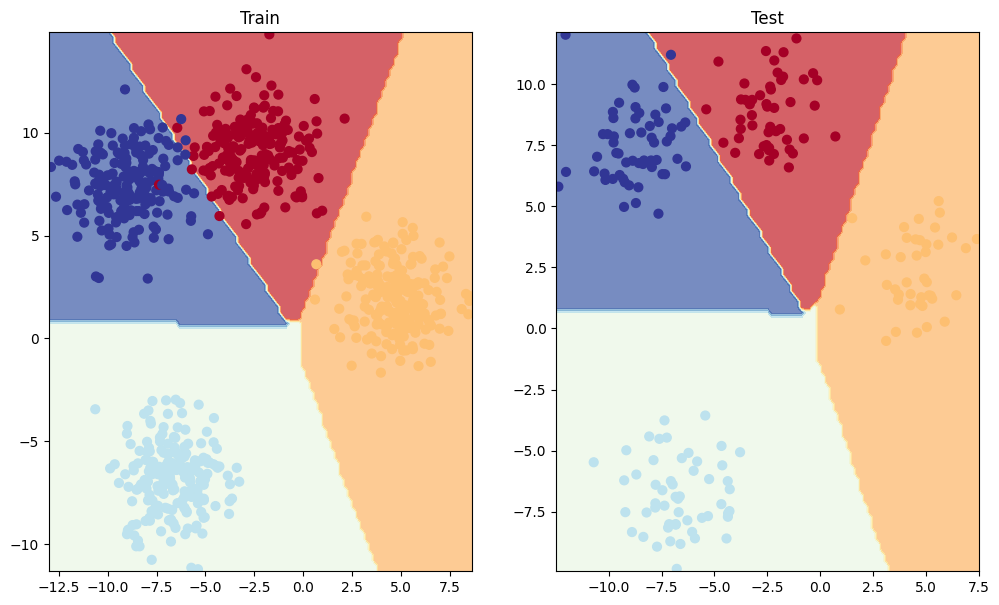

In [18]:
y_preds = y_preds.cpu()
plt.figure(figsize = (12,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blob_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blob_model, X_test, y_test)

AWESOME!

In [34]:
!pip install torchmetrics

# Module Assignment

Import libraries

In [2]:
!pip install torchvision

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),
                             "../src"))
from utils import *
from helper_functions import *

import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <D9493EF5-8DAB-3A5D-85D5-684F04544B84> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3F9923D2-81A5-3EC8-9739-EC0C1C816132> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#Hyperparameters
SEED = 42
TEST_SIZE = 0.2
N_SAMPLES = 1000

Make data

In [3]:
X, y = make_moons(n_samples = N_SAMPLES,
                  noise = 0.07,
                  random_state = SEED)

df = pd.DataFrame({'X1': X[:, 0],
                   "X2": X[:, 1],
                   "label": y})

df.head()

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


In [4]:
df.value_counts("label")

label
0    500
1    500
dtype: int64

Great! Classes are balanced

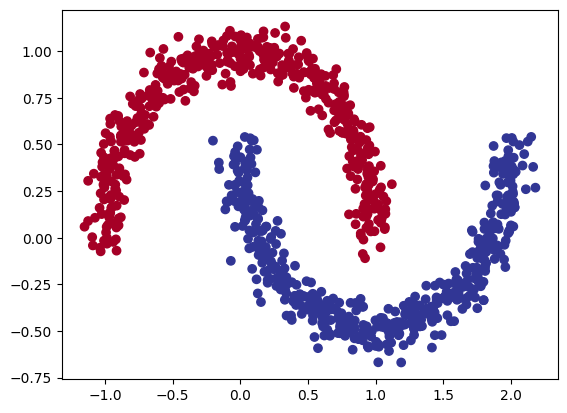

In [5]:
plt.scatter(x = X[:, 0],
            y = X[:,1], 
            c = y,
            cmap = plt.cm.RdYlBu)

In [6]:
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE,
                                                    random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

Build model for binary classification

In [33]:
class MoonClassifier(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(in_features = in_features,
                                out_features = hidden_units)
        self.layer2 = nn.Linear(in_features = hidden_units,
                                out_features = hidden_units)
        self.layer3 = nn.Linear(in_features = hidden_units,
                                out_features = out_features)
        self.relu = nn.ReLU()
    def forward(self, x):
        z = self.layer1(x)
        z = self.relu(z)
        z = self.layer2(z)
        z = self.relu(z)
        z = self.layer3(z)
        return z

In [20]:
device = get_device()
model = MoonClassifier(in_features = 2, out_features = 1, hidden_units = 10).to(device)

Check shape

In [9]:
model.eval()
X_test = X_test.to(device)
with torch.inference_mode():
    logits = model(X_test).squeeze()
logits[0]

tensor(0.0233, device='mps:0')

In [10]:
preds = torch.round(torch.sigmoid(logits)).type(torch.LongTensor)
preds[:5]

tensor([1, 0, 1, 0, 1])

In [11]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

Train model

In [34]:
SEED = 0
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

model = MoonClassifier(in_features = 2, out_features = 1, hidden_units = 10).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
epochs = 1000
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    train_logits = model(X_train).squeeze()
    train_loss = loss_fn(train_logits, y_train)
    train_preds = torch.round(torch.sigmoid(train_logits))
    train_acc = accuracy_fn(y_train, train_preds)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_loss = loss_fn(test_logits, y_test)
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(y_test, test_preds)
        
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.5f}, Train accuracy: {train_acc} | Test loss: {test_loss:.5f}, Test accuracy: {test_acc}")

Epoch: 0 | Train loss: 0.71757, Train accuracy: 50.0 | Test loss: 0.65965, Test accuracy: 50.0
Epoch: 100 | Train loss: 0.20383, Train accuracy: 90.25 | Test loss: 0.21114, Test accuracy: 88.5
Epoch: 200 | Train loss: 0.20275, Train accuracy: 90.25 | Test loss: 0.21143, Test accuracy: 88.0
Epoch: 300 | Train loss: 0.17543, Train accuracy: 91.875 | Test loss: 0.18366, Test accuracy: 90.5
Epoch: 400 | Train loss: 0.00016, Train accuracy: 100.0 | Test loss: 0.00006, Test accuracy: 100.0
Epoch: 500 | Train loss: 0.00010, Train accuracy: 100.0 | Test loss: 0.00004, Test accuracy: 100.0
Epoch: 600 | Train loss: 0.00007, Train accuracy: 100.0 | Test loss: 0.00002, Test accuracy: 100.0
Epoch: 700 | Train loss: 0.00005, Train accuracy: 100.0 | Test loss: 0.00002, Test accuracy: 100.0
Epoch: 800 | Train loss: 0.00004, Train accuracy: 100.0 | Test loss: 0.00001, Test accuracy: 100.0
Epoch: 900 | Train loss: 0.00003, Train accuracy: 100.0 | Test loss: 0.00001, Test accuracy: 100.0


Wow. That's unreal

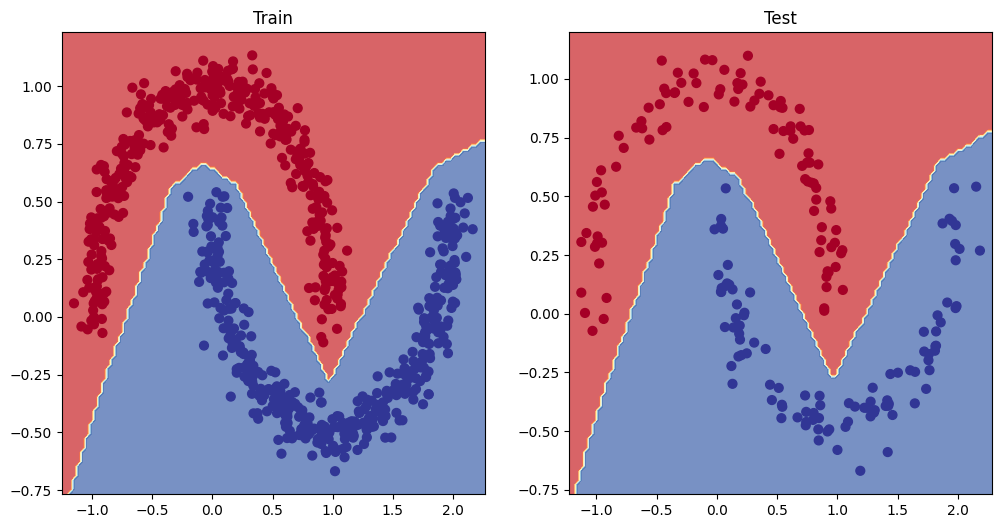

In [36]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)